In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split ,GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import copy
import hashlib



In [2]:
# Load datasets

try:
    fraud_df = pd.read_csv("PS_20174392719_1491204439457_log.csv")
    print(f"fraud data loaded: {fraud_df.shape}")
except FileNotFoundError:
    print("fraud data file not found")
    fraud_df = None

try:
    bank_df = pd.read_csv("bank_transactions.csv")
    print(f"Bank Dataset data loaded: {bank_df.shape}")
except FileNotFoundError:
    print("Bank Dataset data file not found")
    bank_df = None




fraud data loaded: (6362620, 11)
Bank Dataset data loaded: (1048567, 9)


In [3]:
# Explore the fraud dataset
fraud_df.info()
print("Shape:", fraud_df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
Shape: (6362620, 11)


## Data Analysis

In [4]:
fraud_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
# Check unique transaction types
fraud_df['type'].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

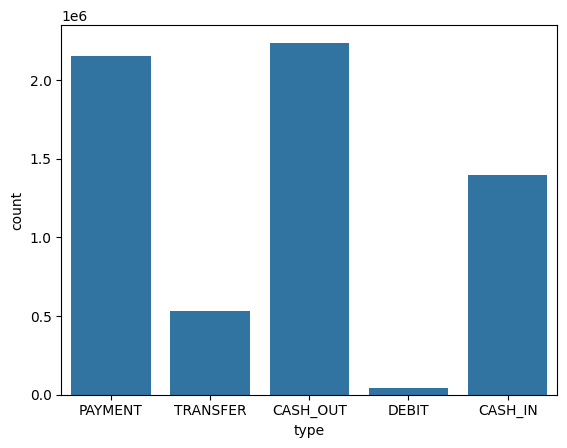

In [6]:
# Visualizing the distribution of transaction types
sns.countplot(x = fraud_df['type'])
plt.show()

In [7]:
# Encode the 'type' column using LabelEncoder
le = LabelEncoder()
fraud_df['type'] = le.fit_transform(fraud_df['type'])
fraud_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,3,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,4,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,3,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


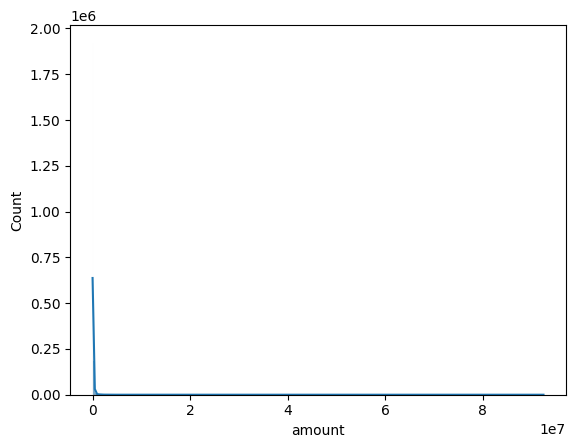

In [8]:
# Plotting the distribution of transaction amounts
sns.histplot(x = fraud_df['amount'] , kde=True)
plt.show()

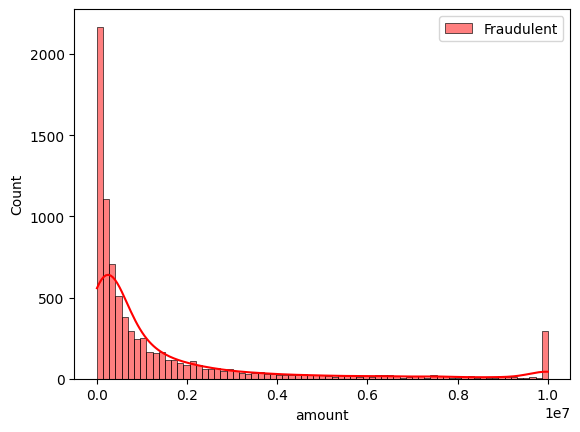

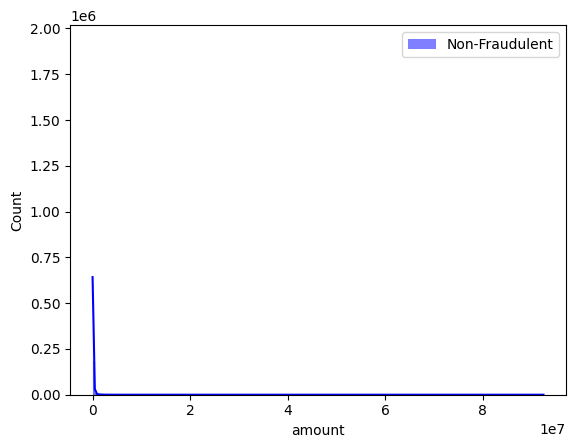

In [9]:
# plot the distribution of transaction amounts for fraudulent and non-fraudulent transactions
sns.histplot(x = fraud_df[fraud_df['isFraud'] == 1]['amount'] , color='red' , kde=True , label='Fraudulent')
plt.legend()
plt.show()
sns.histplot(x = fraud_df[fraud_df['isFraud'] == 0]['amount'] , color='blue' , kde=True , label='Non-Fraudulent')
plt.legend()
plt.show()

In [10]:
# Summary statistics of key features
unique_orig = fraud_df['nameOrig'].nunique()
print(f"\nUnique origin account IDs (nameOrig): {unique_orig}")
print(f"Sample nameOrig: {fraud_df['nameOrig'].iloc[0]}")

old_org = fraud_df['oldbalanceOrg']
print(f"\nOld Origin Balance range: {old_org.min():.2f} - {old_org.max():.2f}")
print(f"Old Origin Balance average: {old_org.mean():.2f}")

new_org = fraud_df['newbalanceOrig']
print(f"\nNew Origin Balance range: {new_org.min():.2f} - {new_org.max():.2f}")
print(f"New Origin Balance average: {new_org.mean():.2f}")

unique_dest = fraud_df['nameDest'].nunique()
print(f"\nUnique destination account IDs (nameDest): {unique_dest}")
print(f"Sample nameDest: {fraud_df['nameDest'].iloc[0]}")

old_dest = fraud_df['oldbalanceDest']
print(f"\nOld Destination Balance range: {old_dest.min():.2f} - {old_dest.max():.2f}")
print(f"Old Destination Balance average: {old_dest.mean():.2f}")

new_dest = fraud_df['newbalanceDest']
print(f"\nNew Destination Balance range: {new_dest.min():.2f} - {new_dest.max():.2f}")
print(f"New Destination Balance average: {new_dest.mean():.2f}")



Unique origin account IDs (nameOrig): 6353307
Sample nameOrig: C1231006815

Old Origin Balance range: 0.00 - 59585040.37
Old Origin Balance average: 833883.10

New Origin Balance range: 0.00 - 49585040.37
New Origin Balance average: 855113.67

Unique destination account IDs (nameDest): 2722362
Sample nameDest: M1979787155

Old Destination Balance range: 0.00 - 356015889.35
Old Destination Balance average: 1100701.67

New Destination Balance range: 0.00 - 356179278.92
New Destination Balance average: 1224996.40


In [11]:
# Explore the bank dataset
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


In [12]:
print("=== BANK DATASET EXPLORATION ===")

print(f"\nDataset shape: {bank_df.shape}")
print(f"\nColumn names: {list(bank_df.columns)}")

unique_tx = bank_df['TransactionID'].nunique()
print(f"\nUnique Transaction IDs: {unique_tx}")

unique_customers = bank_df['CustomerID'].nunique()
print(f"Unique Customer IDs: {unique_customers}")

dob_missing = bank_df['CustomerDOB'].isna().sum()
print(f"\nCustomerDOB missing values: {dob_missing}")
print(f"Sample DOB: {bank_df['CustomerDOB'].dropna().iloc[0]}")

gender_counts = bank_df['CustGender'].value_counts()
print(f"\nGender distribution: {dict(gender_counts)}")
print(f"Missing gender: {bank_df['CustGender'].isna().sum()}")

location_counts = bank_df['CustLocation'].value_counts()
print(f"\nTop 5 Locations: {location_counts.head(5).to_dict()}")
print(f"Missing locations: {bank_df['CustLocation'].isna().sum()}")

bal = bank_df['CustAccountBalance']
print(f"\nCustomer Balance range: {bal.min():.2f} – {bal.max():.2f}")
print(f"Average Customer Balance: {bal.mean():.2f}")
print(f"Missing balances: {bal.isna().sum()}")

print(f"\nTransactionDate sample: {bank_df['TransactionDate'].iloc[0]}")
unique_dates = bank_df['TransactionDate'].nunique()
print(f"Unique transaction dates: {unique_dates}")

tx_time = bank_df['TransactionTime']
print(f"\nTransactionTime range: {tx_time.min()} – {tx_time.max()}")
print(f"Average TransactionTime: {tx_time.mean():.2f}")

tx_amount = bank_df['TransactionAmount (INR)']
print(f"\nTransaction Amount range: {tx_amount.min():.2f} – {tx_amount.max():.2f}")
print(f"Average Transaction Amount: {tx_amount.mean():.2f}")

print("\nBank dataset appears suitable for further analysis.")


=== BANK DATASET EXPLORATION ===

Dataset shape: (1048567, 9)

Column names: ['TransactionID', 'CustomerID', 'CustomerDOB', 'CustGender', 'CustLocation', 'CustAccountBalance', 'TransactionDate', 'TransactionTime', 'TransactionAmount (INR)']

Unique Transaction IDs: 1048567
Unique Customer IDs: 884265

CustomerDOB missing values: 3397
Sample DOB: 10/1/94

Gender distribution: {'M': np.int64(765530), 'F': np.int64(281936), 'T': np.int64(1)}
Missing gender: 1100

Top 5 Locations: {'MUMBAI': 103595, 'NEW DELHI': 84928, 'BANGALORE': 81555, 'GURGAON': 73818, 'DELHI': 71019}
Missing locations: 151

Customer Balance range: 0.00 – 115035495.10
Average Customer Balance: 115403.54
Missing balances: 2369

TransactionDate sample: 2/8/16
Unique transaction dates: 55

TransactionTime range: 0 – 235959
Average TransactionTime: 157087.53

Transaction Amount range: 0.00 – 1560034.99
Average Transaction Amount: 1574.34

Bank dataset appears suitable for further analysis.


### Transaction Risk Classification

In [13]:

#Risk classification based on transaction amounts
amounts = pd.to_numeric(fraud_df['amount'], errors='coerce')
valid_amounts = amounts.dropna()

p25 = valid_amounts.quantile(0.25)
p75 = valid_amounts.quantile(0.75)
mean_amount = valid_amounts.mean()

high_risk_threshold = p75     
low_risk_threshold = p25      

low_risk_count = (valid_amounts < low_risk_threshold).sum()
moderate_risk_count = (
    (valid_amounts >= low_risk_threshold) & (valid_amounts <= high_risk_threshold)
).sum()
high_risk_count = (valid_amounts > high_risk_threshold).sum()

total_valid_tx = len(valid_amounts)

print(" RISK LEVEL THRESHOLDS (based on transaction amounts) ")
print(f"25th percentile: {p25:.2f}")
print(f"75th percentile: {p75:.2f}")
print(f"Mean amount: {mean_amount:.2f}")

print("\n PROPOSED RISK CLASSIFICATION ")
print(f"LOW RISK: Amount < {low_risk_threshold:.2f}")
print(f"MODERATE RISK: Amount {low_risk_threshold:.2f} - {high_risk_threshold:.2f}")
print(f"HIGH RISK: Amount > {high_risk_threshold:.2f}")

print("\n TRANSACTION DISTRIBUTION BY RISK LEVEL ")
print(f"Low Risk: {low_risk_count} transactions ({low_risk_count/total_valid_tx*100:.1f}%)")
print(f"Moderate Risk: {moderate_risk_count} transactions ({moderate_risk_count/total_valid_tx*100:.1f}%)")
print(f"High Risk: {high_risk_count} transactions ({high_risk_count/total_valid_tx*100:.1f}%)")


 RISK LEVEL THRESHOLDS (based on transaction amounts) 
25th percentile: 13389.57
75th percentile: 208721.48
Mean amount: 179861.90

 PROPOSED RISK CLASSIFICATION 
LOW RISK: Amount < 13389.57
MODERATE RISK: Amount 13389.57 - 208721.48
HIGH RISK: Amount > 208721.48

 TRANSACTION DISTRIBUTION BY RISK LEVEL 
Low Risk: 1590653 transactions (25.0%)
Moderate Risk: 3181312 transactions (50.0%)
High Risk: 1590655 transactions (25.0%)


## Preprocessing

In [14]:
# Create a new feature 'balance_diff' as the difference between 'oldbalanceOrg' and 'newbalanceOrig'
fraud_df['balance_diff'] = fraud_df['oldbalanceOrg'] - fraud_df['newbalanceOrig']
fraud_df['balance_diff'].head()

0     9839.64
1     1864.28
2      181.00
3      181.00
4    11668.14
Name: balance_diff, dtype: float64

In [24]:

# Prepare balanced samples for modeling
fraud_sample = fraud_df.sample(n=300_000, random_state=42)   
bank_sample = bank_df.sample(n=200_000, random_state=42)  

fraud_positive = fraud_df[fraud_df['isFraud'] == 1].sample(n=8213, random_state=42)
fraud_sample = pd.concat([fraud_sample, fraud_positive]).drop_duplicates().reset_index(drop=True)

print("Fraud sample size:", len(fraud_sample))
print("bank  sample size:", len(bank_sample))

fraud_clean = fraud_sample.rename(columns={
    "nameOrig": "user_orig",
    "nameDest": "merchant",
    "amount": "amount",
    "isFraud": "is_fraud" ,
    "step": "ts"
})[["user_orig", "merchant", "amount", "ts", "is_fraud" ,"balance_diff"]]

def stable_device_id(x):
    return int(hashlib.md5(x.encode()).hexdigest(), 16) % 10000

fraud_clean["device_id"] = fraud_clean["user_orig"].apply(stable_device_id)

Fraud sample size: 307825
bank  sample size: 200000


In [26]:
# Convert PaySim step to datetime: 1 step = 1 hour
fraud_clean["ts_dt"] = (
    pd.Timestamp("2017-01-01")
    + pd.to_timedelta(fraud_clean["ts"], unit="h")
)

fraud_clean = fraud_clean.sort_values(["user_orig", "ts_dt"]).reset_index(drop=True)

# Compute velocity: number of transactions in the last 1 hour per user
velocity_series = (
    fraud_clean
    .groupby("user_orig")
    .rolling("1h", on="ts_dt")["ts_dt"]
    .count()
)

# Drop the group level index and align by position
fraud_clean["velocity_1h"] = (
    velocity_series
    .reset_index(level=0, drop=True)
    .values
    .astype(int)
)





In [49]:
# Identify new devices for each user
fraud_clean["is_new_device"] = (
    ~fraud_clean.duplicated(subset=["user_orig", "device_id"])
).astype(int)

# Normalize amount per user using z-score
fraud_clean["user_amount_z"] = (
    fraud_clean
    .groupby("user_orig")["amount"]
    .transform(lambda x: (x - x.mean()) / (x.std(ddof=0) if x.std(ddof=0) != 0 else 1))
    .fillna(0)
)

print(" Fraud clean preview:")
display(fraud_clean.head(5))

transactions_fraud = fraud_clean[[
    "amount","merchant","device_id","ts",'balance_diff',
    "velocity_1h","is_new_device","user_amount_z","is_fraud"
]]




 Fraud clean preview:


,user_orig,merchant,amount,ts,is_fraud,balance_diff,device_id,ts_dt,velocity_1h,is_new_device,user_amount_z
0,C1000009135,M2120765976,3849.38,19,0,3849.38,4447,2017-01-01 19:00:00,1,1,0.0
1,C1000015836,C941241676,77027.49,163,0,19787.00,8747,2017-01-07 19:00:00,1,1,0.0
2,C1000018217,C187378283,290045.17,96,0,0.00,835,2017-01-05 00:00:00,1,1,0.0
3,C1000018718,M1509499092,32100.16,138,0,32100.16,6427,2017-01-06 18:00:00,1,1,0.0
4,C1000020710,M268222876,1898.36,257,0,1898.36,7378,2017-01-11 17:00:00,1,1,0.0


In [50]:

# Feature engineering and dataset balancing
df = transactions_fraud.copy()


df["merchant_prefix"] = df["merchant"].str[0]

df["merchant_number"] = df["merchant"].str[1:].astype(int)

df["merchant"] = df["merchant_prefix"].map({'C' : 0 , 'M': 1})
df = df.drop(columns=["merchant_prefix"])

df["device_num"] = df["device_id"] % 10000  

df["device_freq"] = df["device_id"].map(df["device_id"].value_counts())

df = df.drop(columns=["device_id"])


df = df.drop(columns=["ts"])


fraud_df = df[df["is_fraud"] == 1]
nonfraud_df = df[df["is_fraud"] == 0]

nonfraud_sample = nonfraud_df.sample(n=len(fraud_df), random_state=42)

balanced_df = pd.concat([fraud_df, nonfraud_sample], ignore_index=True)

balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

feature_cols = [
    "amount",
    "balance_diff",
    "merchant",
    "merchant_number",
    "velocity_1h",
    "device_num",
    "device_freq",
    "is_new_device",
    "user_amount_z"
]
X = balanced_df[feature_cols]
y = balanced_df['is_fraud']

# First split: train vs temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    random_state=42
)

# Second split: validation vs test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=42
)

X_train.shape , X_test.shape , y_train.shape , y_test.shape


((11498, 9), (2464, 9), (11498,), (2464,))

## Modeling

### LogisticRegression (Khatija)

In [51]:
## LogisticRegression
model_log = LogisticRegression(solver='lbfgs', max_iter=5000)
model_log.fit(X_train ,y_train)
y_pred_log = model_log.predict(X_test)
y_prob_log = model_log.predict_proba(X_test)[:, 1]


## LogisticRegression with GridCV
grid={"C":np.logspace(-3,3,7), "l1_ratio":[0, 0.5, 1]}
logreg=LogisticRegression(solver='saga', max_iter=5000, tol=1e-3)
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train,y_train)

logreg2=LogisticRegression(C=0.001, l1_ratio=0, solver='saga', max_iter=5000, tol=1e-3)
logreg2.fit(X_train,y_train)
y_pred_log_with_cv = logreg2.predict(X_test)
y_prob_log_with_cv = logreg2.predict_proba(X_test)[:, 1]



### RandomForestClassifier (Khatija)

In [33]:

clf = RandomForestClassifier(
    n_estimators=300,max_depth=None,random_state=42)
clf.fit(X_train, y_train)

y_pred_clf = clf.predict(X_test)
y_prob_clf = clf.predict_proba(X_test)[:, 1]


param_grid_rf = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}


rf = RandomForestClassifier(random_state=42)

grid_rf = GridSearchCV(estimator=rf,param_grid=param_grid_rf,n_jobs=-1,verbose=0)

grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_

y_pred_rf = best_rf.predict(X_test)
y_prob_rf = best_rf.predict_proba(X_test)[:, 1]



### DecisionTreeClassifier (Khatija)

In [34]:
DT_tree = DecisionTreeClassifier(max_depth=None,random_state=42,)
DT_tree.fit(X_train, y_train)

y_pred_DT = DT_tree.predict(X_test)
y_prob_DT = DT_tree.predict_proba(X_test)[:, 1]

param_grid_dt = {
    'max_depth': [None, 5, 10, 15, 20, 30],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['gini', 'entropy', 'log_loss']
}
dt = DecisionTreeClassifier(random_state=42)

grid_dt = GridSearchCV(estimator=dt,param_grid=param_grid_dt,scoring='recall',cv=3,n_jobs=-1,verbose=0)

grid_dt.fit(X_train, y_train)

best_dt = grid_dt.best_estimator_

y_pred_dt = best_dt.predict(X_test)
y_prob_dt = best_dt.predict_proba(X_test)[:, 1]



### SVM (Khatija)

In [35]:
svm_model = SVC(probability=True)   
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)
y_prob_svm = svm_model.predict_proba(X_test)[:, 1]




pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True))    
])

param_grid_svm = {
    'svm__C': [0.1, 1, 10, 50, 100],
    'svm__kernel': ['linear', 'rbf'],
    'svm__gamma': ['scale', 'auto']
}

grid_svm = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid_svm,
    scoring='recall',
    cv=3,
    n_jobs=-1
)

grid_svm.fit(X_train, y_train)

best_svm = grid_svm.best_estimator_

y_pred_svm_cv = best_svm.predict(X_test)
y_prob_svm_cv = best_svm.predict_proba(X_test)[:, 1]



### Neural Network (Gadi)

In [52]:
# Standardize features

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)


In [37]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.25),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.25),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.1),

            nn.Linear(32, 16),
            nn.LeakyReLU(0.1),

            nn.Linear(16, 1)  # logits
        )

    def forward(self, x):
        return self.layers(x).squeeze(1)

    
model = MLP(input_dim=X_train.shape[1])
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)




In [38]:
epochs = 300
patience = 15  
# minimum improvement to count as progress        
min_delta = 1e-4       

best_val_loss = float("inf")
best_state_dict = None
best_epoch = 0
epochs_without_improvement = 0

train_losses = []
val_losses = []

for epoch in range(epochs):
    # ---- training ----
    model.train()
    train_loss = 0.0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    # ---- validation ----
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            logits = model(xb)
            loss = criterion(logits, yb)
            val_loss += loss.item()

    val_loss /= len(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(
        f"Epoch {epoch+1}/{epochs} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f}"
    )

    # ---- early stopping logic ----
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        best_state_dict = copy.deepcopy(model.state_dict())
        best_epoch = epoch + 1
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(
                f"Early stopping triggered at epoch {epoch+1}. "
                f"Best epoch was {best_epoch}."
            )
            break



# Load the best model state
print(f"Best model from epoch {best_epoch} with val loss {best_val_loss:.4f}")
model.load_state_dict(best_state_dict)
print(f"Loaded best model from epoch {best_epoch}")


Epoch 1/300 | Train Loss: 0.6337 | Val Loss: 0.5782
Epoch 2/300 | Train Loss: 0.5159 | Val Loss: 0.4629
Epoch 3/300 | Train Loss: 0.4313 | Val Loss: 0.3787
Epoch 4/300 | Train Loss: 0.3913 | Val Loss: 0.3357
Epoch 5/300 | Train Loss: 0.3759 | Val Loss: 0.3199
Epoch 6/300 | Train Loss: 0.3604 | Val Loss: 0.3048
Epoch 7/300 | Train Loss: 0.3437 | Val Loss: 0.2999
Epoch 8/300 | Train Loss: 0.3322 | Val Loss: 0.2817
Epoch 9/300 | Train Loss: 0.3171 | Val Loss: 0.2837
Epoch 10/300 | Train Loss: 0.2934 | Val Loss: 0.2538
Epoch 11/300 | Train Loss: 0.2721 | Val Loss: 0.2316
Epoch 12/300 | Train Loss: 0.2624 | Val Loss: 0.2512
Epoch 13/300 | Train Loss: 0.2516 | Val Loss: 0.2159
Epoch 14/300 | Train Loss: 0.2410 | Val Loss: 0.2256
Epoch 15/300 | Train Loss: 0.2471 | Val Loss: 0.1974
Epoch 16/300 | Train Loss: 0.2392 | Val Loss: 0.1927
Epoch 17/300 | Train Loss: 0.2225 | Val Loss: 0.1889
Epoch 18/300 | Train Loss: 0.2213 | Val Loss: 0.1852
Epoch 19/300 | Train Loss: 0.2139 | Val Loss: 0.1666
Ep

## Evaluation

In [39]:
model.eval()
with torch.no_grad():
    logits = model(X_test_tensor)
    y_prob_pytorch = torch.sigmoid(logits).numpy()

auc_pytorch = roc_auc_score(y_test, y_prob_pytorch)
print("PyTorch Model AUC:", auc_pytorch)

PyTorch Model AUC: 0.9886930236970821


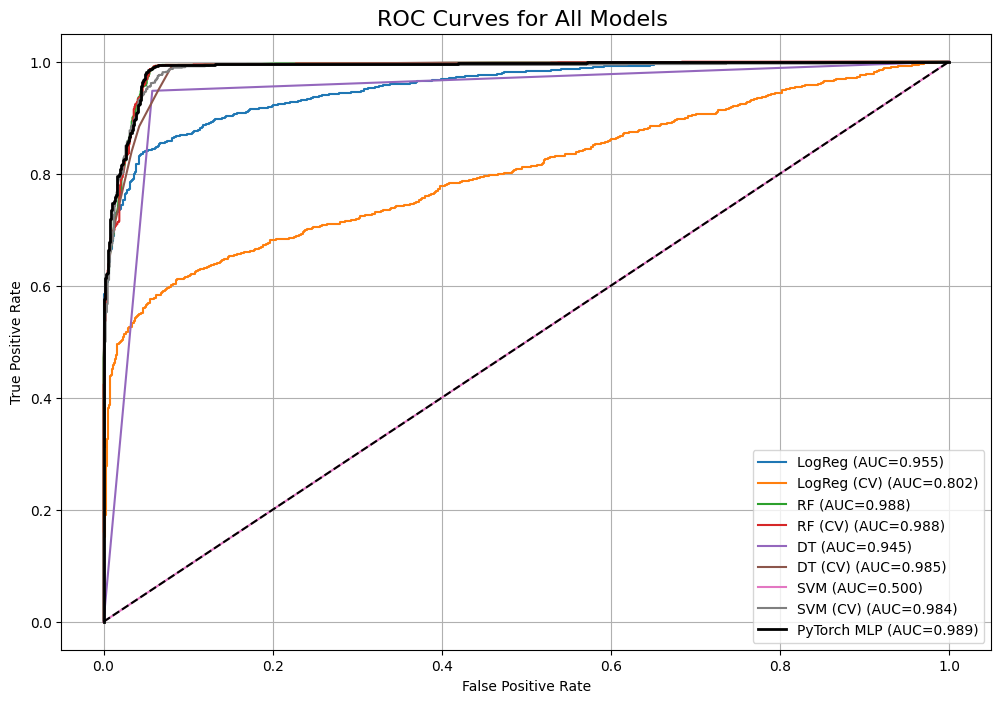

In [41]:
# Plot ROC curves for all models
auc_pytorch = roc_auc_score(y_test, y_prob_pytorch)

results = {
    "Logistic Regression": roc_auc_score(y_test, y_prob_log),
    "LogReg (GridCV)": roc_auc_score(y_test, y_prob_log_with_cv),
    "Random Forest": roc_auc_score(y_test, y_prob_clf),
    "Random Forest (GridCV)": roc_auc_score(y_test, y_prob_rf),
    "Decision Tree": roc_auc_score(y_test, y_prob_DT),
    "Decision Tree (GridCV)": roc_auc_score(y_test, y_prob_dt),
    "SVM (Base)": roc_auc_score(y_test, y_prob_svm),
    "SVM (GridCV)": roc_auc_score(y_test, y_prob_svm_cv),
    "PyTorch MLP": auc_pytorch
}

plt.figure(figsize=(12, 8))

models_prob = {
    "LogReg": y_prob_log,
    "LogReg (CV)": y_prob_log_with_cv,
    "RF": y_prob_clf,
    "RF (CV)": y_prob_rf,
    "DT": y_prob_DT,
    "DT (CV)": y_prob_dt,
    "SVM": y_prob_svm ,
    "SVM (CV)": y_prob_svm_cv

}

for model_name, prob in models_prob.items():
    fpr, tpr, _ = roc_curve(y_test, prob)
    auc_value = roc_auc_score(y_test, prob)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC={auc_value:.3f})")

fpr, tpr, _ = roc_curve(y_test, y_prob_pytorch)
plt.plot(fpr, tpr, label=f"PyTorch MLP (AUC={auc_pytorch:.3f})", linewidth=2, color='black')

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves for All Models ", fontsize=16)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)




plt.legend(loc='lower right')
plt.show()


In [42]:

# Compile metrics into a table
metrics_table = {}

model_preds = {
    "LogReg": y_pred_log,
    "LogReg (CV)": y_pred_log_with_cv,
    "RF": y_pred_clf,
    "RF (CV)": y_pred_rf,
    "DT": y_pred_DT,
    "DT (CV)": y_pred_dt,
    "SVM": y_pred_svm,
    "SVM (CV)": y_pred_svm_cv,
    "PyTorch": (y_prob_pytorch > 0.5).astype(int)
}

for name, pred in model_preds.items():
    metrics_table[name] = {
        "Accuracy": accuracy_score(y_test, pred),
        "Precision": precision_score(y_test, pred),
        "Recall": recall_score(y_test, pred),
        "F1 Score": f1_score(y_test, pred)
    }

df_metrics = pd.DataFrame(metrics_table).T
df_metrics


,Accuracy,Precision,Recall,F1 Score
LogReg,0.892857,0.936823,0.842532,0.887179
LogReg (CV),0.759740,0.891198,0.591721,0.711220
RF,0.965503,0.944229,0.989448,0.966310
RF (CV),0.966315,0.943629,0.991883,0.967155
DT,0.945211,0.942696,0.948052,0.945366
DT (CV),0.955357,0.923077,0.993506,0.956998
SVM,0.500000,0.500000,0.705357,0.585185
SVM (CV),0.939123,0.897210,0.991883,0.942174
PyTorch,0.961445,0.933638,0.993506,0.962643


In [43]:
best_models = {
    "Best Accuracy": df_metrics["Accuracy"].idxmax(),
    "Best Precision": df_metrics["Precision"].idxmax(),
    "Best Recall": df_metrics["Recall"].idxmax(),
    "Best F1 Score": df_metrics["F1 Score"].idxmax()
}

best_models

{'Best Accuracy': 'RF (CV)',
 'Best Precision': 'RF',
 'Best Recall': 'DT (CV)',
 'Best F1 Score': 'RF (CV)'}

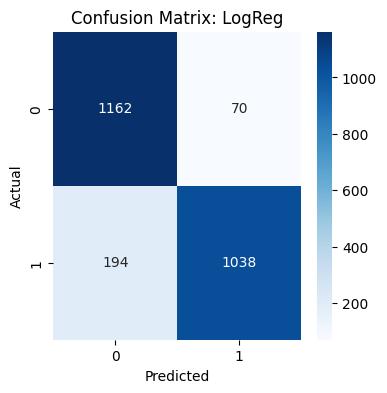

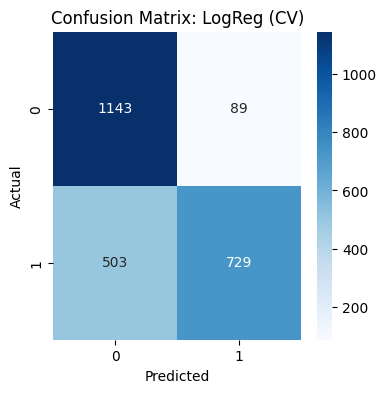

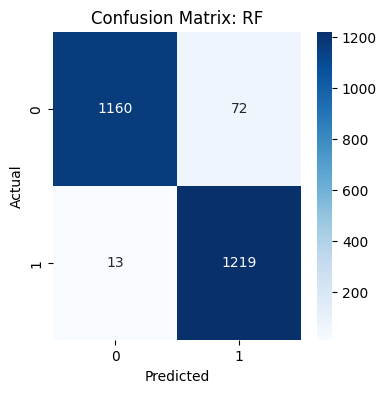

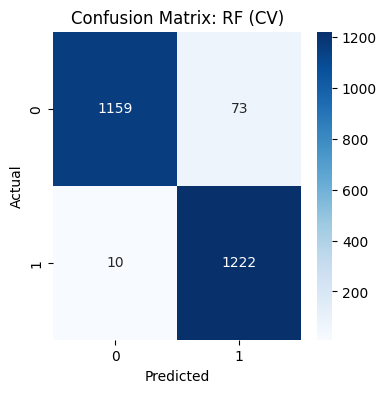

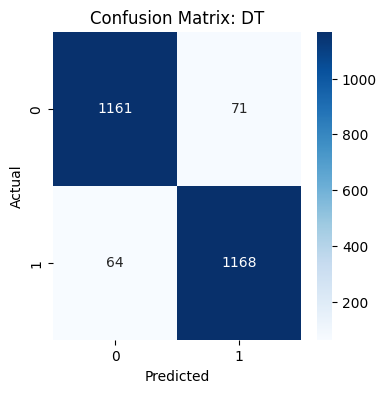

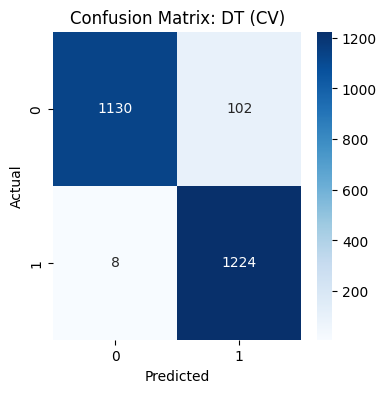

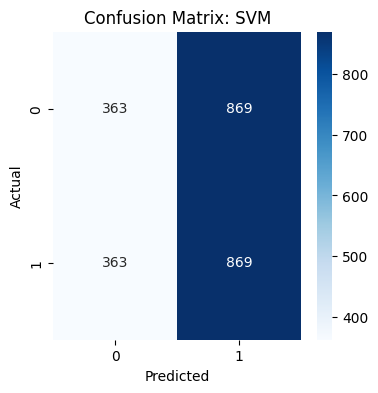

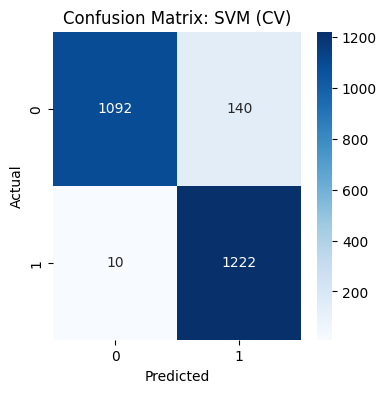

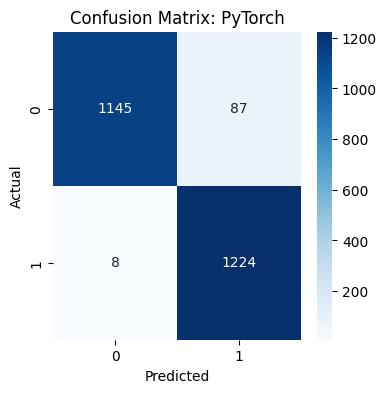

In [44]:
# Plot confusion matrices for all models
for name, pred in model_preds.items():
    plt.figure(figsize=(4,4))
    sns.heatmap(confusion_matrix(y_test, pred), annot=True, cmap='Blues', fmt='d')
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


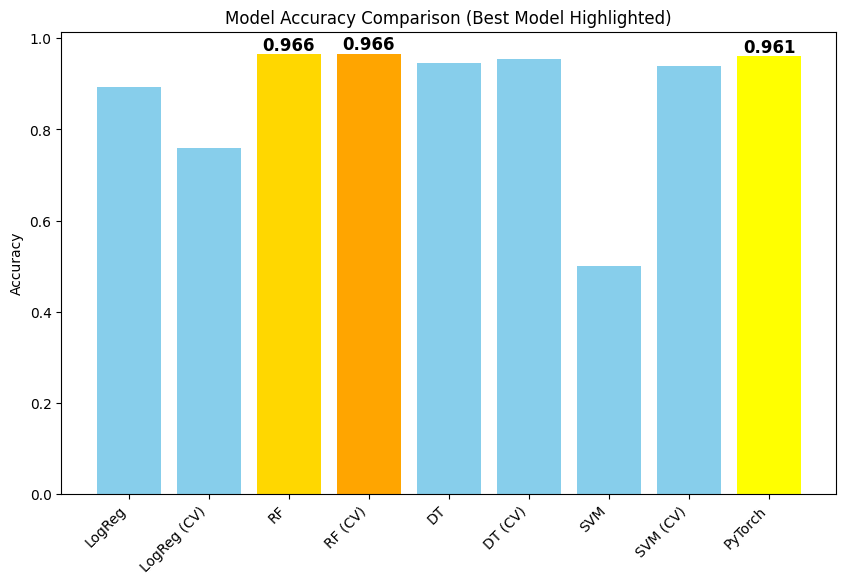

In [45]:
# Bar chart of model accuracies with best model highlighted
accuracy_values = df_metrics["Accuracy"]

top_3_models = accuracy_values.nlargest(3)
best_model = top_3_models.index[0]
best_value = top_3_models.iloc[0]
second_best_model = top_3_models.index[1]
second_best_value = top_3_models.iloc[1]
third_best_model = top_3_models.index[2]    
third_best_value = top_3_models.iloc[2]

colors = ["orange" if model == best_model else "gold" if model == second_best_model else "yellow" if model == third_best_model else "skyblue" for model in accuracy_values.index]

plt.figure(figsize=(10,6))
plt.bar(accuracy_values.index, accuracy_values.values, color=colors)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison (Best Model Highlighted)")

plt.text(
    best_model,
    best_value,
    f"{best_value:.3f}",
    ha='center',
    va='bottom',
    fontsize=12,
    fontweight='bold'
)
plt.text(
    second_best_model,
    second_best_value,
    f"{second_best_value:.3f}",
    ha='center',
    va='bottom',
    fontsize=12,
    fontweight='bold'
)
plt.text(
    third_best_model,
    third_best_value,
    f"{third_best_value:.3f}",
    ha='center',
    va='bottom',
    fontsize=12,
    fontweight='bold'
)


plt.show()

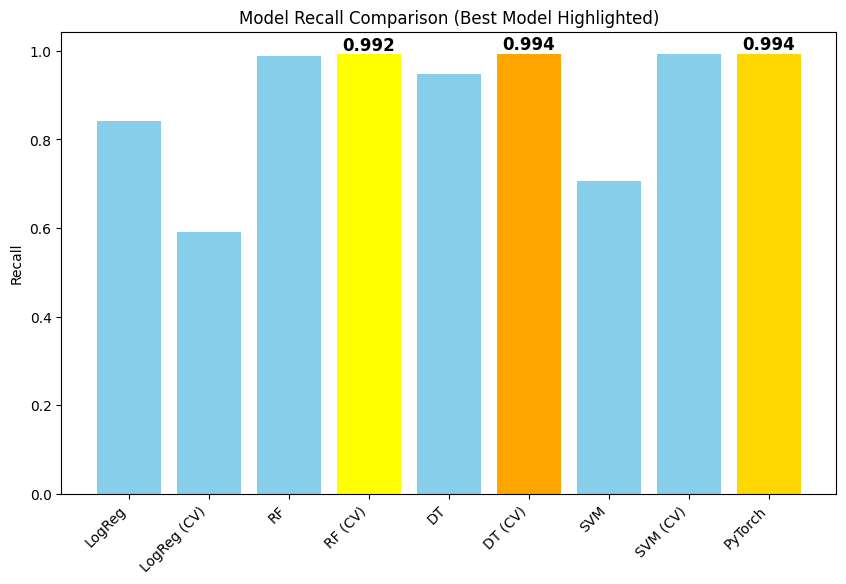

In [46]:
# Bar chart of model recall with best model highlighted
recall_values = df_metrics["Recall"]

top_3_models = recall_values.nlargest(3)
best_model = top_3_models.index[0]
best_value = top_3_models.iloc[0]
second_best_model = top_3_models.index[1]
second_best_value = top_3_models.iloc[1]
third_best_model = top_3_models.index[2]    
third_best_value = top_3_models.iloc[2]

colors = ["orange" if model == best_model else "gold" if model == second_best_model else "yellow" if model == third_best_model else "skyblue" for model in accuracy_values.index]

plt.figure(figsize=(10,6))
plt.bar(recall_values.index, recall_values.values, color=colors)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Recall")
plt.title("Model Recall Comparison (Best Model Highlighted)")

plt.text(
    best_model,
    best_value,
    f"{best_value:.3f}",
    ha='center',
    va='bottom',
    fontsize=12,
    fontweight='bold'
)
plt.text(
    second_best_model,
    second_best_value,
    f"{second_best_value:.3f}",
    ha='center',
    va='bottom',
    fontsize=12,
    fontweight='bold'
)
plt.text(
    third_best_model,
    third_best_value,
    f"{third_best_value:.3f}",
    ha='center',
    va='bottom',
    fontsize=12,
    fontweight='bold'
)


plt.show()